## Define test method

In [1]:
import gym
import pybullet as p
import pybullet_envs
import pygame
import numpy as np
import tensorflow as tf
from tensorflow import keras

from datetime import datetime
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display
os.environ["SDL_VIDEODRIVER"] = "dummy"
from gym import wrappers

import a2cagent_continuous_2 as a2cc
import continuous_cartpole as continuous_cartpole

pybullet build time: May 20 2022 19:44:17
2022-12-10 10:03:30.247761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 10:03:31.293322: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-10 10:03:31.354674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 10:03:31.354861: I tensorflow/compiler/xla/strea

In [2]:
def test(num_episodes=10, env_str="ContinuousCartPoleEnv", policy="A2C061220221730ContinuousCartPoleEnv_collapse", add_branch_layer=False, use_existing_policy=True, state_normalization=False, batch_normalization=False, specification=""):
    # check for custom CARTPOLE ENV
    custom_cart = False
    if (env_str == "ContinuousCartPoleEnv"):
        custom_cart = True

    # load environment
    env = None
    if (custom_cart == True):
        env = continuous_cartpole.ContinuousCartPoleEnv()
    else:
        env = gym.make(env_str) #render_mode='rgb_array'
    #env = wrappers.Monitor(env, "./test_continuous", force=True)
    s0 = env.reset()

    act_space_low = env.action_space.low[0]
    act_space_high = env.action_space.high[0]
    obs_dim = env.observation_space.shape[0]

    # state normalisation
    state_space_samples = np.array(
        [env.observation_space.sample() for x in range(6400)])
    if (env_str == "CartPoleContinuousBulletEnv-v0" or custom_cart == True):
        # method does not yield reasonable results for CartPole, so we load some historical state data
        state_space_samples = np.loadtxt(os.getcwd()+"/obs-samples/norm_a.txt")

    # initiate agent
    model = a2cc.A2CAgent(s0, act_space_high, act_space_low, state_space_samples, obs_dim, state_normalization, batch_normalization,
                          use_existing_policy, add_branch_layer)
    # compile NN with inherited keras-method
    # add gradient clipping keras.optimizers.Adam(clipvalue=0.5) clipping keras.optimizers.Adam(clipnorm=1.0)
    model.compile(optimizer=keras.optimizers.Adam(), loss=[
                  model.critic_loss, model.actor_loss])

    # load weights from existing model
    if use_existing_policy == True:
        model.train_on_batch(tf.stack(np.zeros((model.batch_size, model.obs_dim))), [
                             np.zeros((model.batch_size, 1)), np.zeros((model.batch_size, 2))])
        model.load_weights(
            model.my_path+'/training_continuous/models/' + policy+"/")

        """non WSL version"""
        # Tk().withdraw()
        # filename = askopenfilename()
        # model.load_weights(filename)

    # set up TensorBoard to visualize progress
    train_writer = tf.summary.create_file_writer(
        model.my_path + '/test_continuous/tensorboard'+policy+"_"+specification)

    # environment interaction
    episode_reward_sum = 0
    s = env.reset()
    episode = 1
    step=0
    while(episode<=num_episodes):
        # obtain action distibution
        _, _ = model(s.reshape(1, -1))
        a_t, V_t = model.action_value(s.reshape(1, -1))  # choose action
        s_new, reward, done, _ = env.step(a_t.numpy()[0])  # make step
        
        #render1 - in jupyter notebook
        if (step%model.render_size==0):
            clear_output(wait=True)
            x=env.render(mode='rgb_array')
            plt.imshow( x )
            plt.show()

        episode_reward_sum += reward
        s = s_new

        # handle end of episode
        if done:
            s = env.reset()
            # print(
            #     f"Episode: {episode}, latest episode reward: {episode_reward_sum}")
            with train_writer.as_default():
                tf.summary.scalar('rewards', episode_reward_sum, episode)

            episode_reward_sum = 0
            episode += 1

    env.close()


## Set Up Test Run

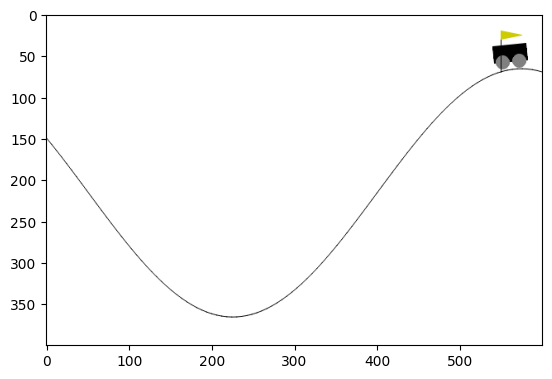

In [3]:
# "CartPoleContinuousBulletEnv-v0", "ContinuousCartPoleEnv", "MountainCarContinuous-v0", "Pendulum-v1",  "HopperBulletEnv-v0", "(LunarLanderContinuous-v2")
test(num_episodes=1, env_str="MountainCarContinuous-v0", policy="A2C101220220847MountainCarContinuous-v0_learns_insufficiently",
        specification="test_run", add_branch_layer=True, state_normalization=True, batch_normalization=True, use_existing_policy=False)